In [1]:
import tensorflow as tf
import numpy as np

import struct
import os

import matplotlib.pyplot as plt
import cv2
%matplotlib notebook

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


(64, 64, 3)


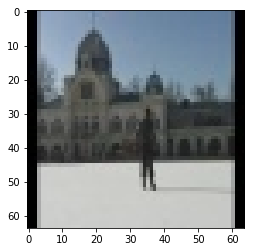

In [2]:
img = cv2.imread('./resized_images/35.jpg')
#resized_image1 = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA) 

print(np.array(img).shape)
plt.imshow(img)

plt.show()

## The image's helper class of Church Outdoor images

When an instance of this class is created, it reads in and combines all church outdoor images, being collected from LSUN image dataset, in RGB format and put them into a single data array. It further provides a class to iterate over the data in batches of a certain size.
The original images are in BGR format so that they can be read directly to RGB format using opencv library when loading the images since "imread" function reads images in reverse (if RGB, it is loaded as BGR and vice versa.). This is in order to save time when loading the data that should be already ready before loading it.
The images are converted into float images when starting training!

In [6]:
class Church_Outdoors():
    
    def __init__(self, direc):
        
        
        self._test_data = self._load(direc)
        
        
    def _load(self, file_name):
        
        images = []
        for file in os.listdir(file_name):
            extension = os.path.splitext(file)[1]
            imagePath = os.path.join(file_name, file)
            images.append(cv2.imread(imagePath, cv2.IMREAD_UNCHANGED))
        return np.array(images)
    
    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, batch_size)
    
    
    def _get_batch(self, data, batch_size):
        samples_n = data.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
            
        random_indices = np.random.choice(data.shape[0], samples_n, replace = False)
        data = data[random_indices]
        
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off]

In [7]:
churches = Church_Outdoors("./resized_images/")


## Checking the dataset



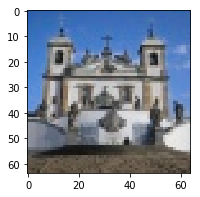

In [10]:
images = next(churches.get_test_batch(5))


plt.figure(figsize=(3,3))
plt.imshow(images[0])
plt.show()

# Image processing (for color spaces) helpers

Taken from https://github.com/Armour/Automatic-Image-Colorization/blob/master/image_helper.py

In [14]:

"""

Helper functions for image manipulation

"""


def rgb_to_yuv(rgb_image, scope, normalize_yuv=True):

    """

    Convert image color space from RGB to YUV

    :param rgb_image: an image with RGB color space

    :param scope: scope for this function

    :return: an image with YUV color space

    """

    with tf.name_scope(scope):

        # Get r, g, b channel

        _r = tf.slice(rgb_image, [0, 0, 0, 0], [-1, -1, -1, 1])

        _g = tf.slice(rgb_image, [0, 0, 0, 1], [-1, -1, -1, 1])

        _b = tf.slice(rgb_image, [0, 0, 0, 2], [-1, -1, -1, 1])



        # Calculate y, u, v channel

        _y = (0.299 * _r) + (0.587 * _g) + (0.114 * _b)

        _u = (-0.14713 * _r) - (0.28886 * _g) + (0.436 * _b)

        _v = (0.615 * _r) - (0.51499 * _g) - (0.10001 * _b)



        # Get image with YUV color space

        yuv_image = tf.concat([_y, _u, _v], 3)



        if normalize_yuv:

            # Normalize y, u, v channels

            yuv_image = normalized_yuv(yuv_image)



        return yuv_image





def yuv_to_rgb(yuv_image, scope, normalize_yuv=True):

    """

    Convert image color space from YUV to RGB

    :param yuv_image: an image with YUV color space

    :param scope: scope for this function

    :return: an image with RGB color space

    """

    with tf.name_scope(scope):

        if normalize_yuv:

            # Denormalize y, u, v channels

            yuv_image = denormalized_yuv(yuv_image)



        # Get y, u, v channel

        _y = tf.slice(yuv_image, [0, 0, 0, 0], [-1, -1, -1, 1])

        _u = tf.slice(yuv_image, [0, 0, 0, 1], [-1, -1, -1, 1])

        _v = tf.slice(yuv_image, [0, 0, 0, 2], [-1, -1, -1, 1])



        # Calculate r, g, b channel

        _r = (_y + 1.13983 * _v) * 255

        _g = (_y - 0.39464 * _u - 0.58060 * _v) * 255

        _b = (_y + 2.03211 * _u) * 255



        # Get image with RGB color space

        rgb_image = tf.concat([_r, _g, _b], 3)

        rgb_image = tf.maximum(rgb_image, tf.zeros(rgb_image.get_shape(), dtype=tf.float32))

        rgb_image = tf.minimum(rgb_image, tf.multiply(tf.ones(rgb_image.get_shape(), dtype=tf.float32), 255))

        rgb_image = tf.div(rgb_image, 255)



        return rgb_image




def normalized_yuv(yuv_images, y_norm_para = 0.5, u_norm_para = 0.436, v_norm_para = 0.615):

    """

    Normalize the yuv image data

    :param yuv_images: the YUV images that needs normalization

    :return: the normalized yuv image

    """

    with tf.name_scope("normalize_yuv"):

        # Split channels

        channel_y = tf.slice(yuv_images, [0, 0, 0, 0], [-1, -1, -1, 1])

        channel_u = tf.slice(yuv_images, [0, 0, 0, 1], [-1, -1, -1, 1])

        channel_v = tf.slice(yuv_images, [0, 0, 0, 2], [-1, -1, -1, 1])



        # Normalize u, v channels

        channel_u = tf.div(channel_u, u_norm_para)

        channel_v = tf.div(channel_v, v_norm_para)

        channel_u = tf.add(tf.div(channel_u, 2.0), 0.5, name="channel_u")

        channel_v = tf.add(tf.div(channel_v, 2.0), 0.5, name="channel_v")



        # Add channel data

        channel_yuv = tf.concat([channel_y, channel_u, channel_v], 3, name="channel_yuv")

        return channel_yuv





def denormalized_yuv(yuv_images, y_norm_para = 0.5, u_norm_para = 0.436, v_norm_para = 0.615):

    """

    Denormalize the yuv image data

    :param yuv_images: the YUV images that needs denormalization

    :return: the denormalized yuv image

    """

    with tf.name_scope("denormalize_yuv"):

        # Split channels

        channel_y = tf.slice(yuv_images, [0, 0, 0, 0], [-1, -1, -1, 1])

        channel_u = tf.slice(yuv_images, [0, 0, 0, 1], [-1, -1, -1, 1])

        channel_v = tf.slice(yuv_images, [0, 0, 0, 2], [-1, -1, -1, 1])



        # Denormalize u, v channels

        channel_u = tf.multiply(tf.subtract(channel_u, 0.5), 2.0)

        channel_v = tf.multiply(tf.subtract(channel_v, 0.5), 2.0)

        channel_u = tf.multiply(channel_u, u_norm_para, name="channel_u")

        channel_v = tf.multiply(channel_v, v_norm_para, name="channel_v")



        # Add channel data

        channel_yuv = tf.concat([channel_y, channel_u, channel_v], 3,name="channel_yuv")

        return channel_yuv




In [15]:
batch_size = 128

image_size = 64

z_dim = 100

learning_rate = 0.01

epochs = 5

validation_step = 100

save_step = 30

INFO:tensorflow:Restoring parameters from ./dcgan.chkpt-4920


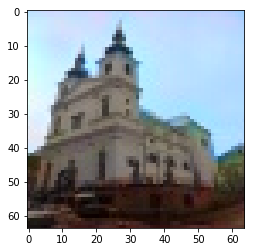

In [16]:
with tf.Session() as session:
    #First let's load meta graph and restore weights
    saver = tf.train.import_meta_graph('dcgan.chkpt-4920.meta')
    saver.restore(session,tf.train.latest_checkpoint('./'))


    # Now, let's access and create placeholders variables and
    # create feed-dict to feed new data
    
    images_valid = next(churches.get_test_batch(batch_size))
    zs_valid = np.random.uniform(low=0, high=1, size=(batch_size, z_dim))

     
    graph = tf.get_default_graph()
    is_ = graph.get_tensor_by_name("Placeholder:0")
    reals = graph.get_tensor_by_name("real_images:0")
    z_ = graph.get_tensor_by_name("z:0")
    feed_dict ={is_:True,reals:images_valid,z_:zs_valid}

    #Now, access the op that you want to run. 
    generated= graph.get_tensor_by_name("predict_yuv:0")
    gen = yuv_to_rgb(generated, "yuv2rgb_for_pred_image")

    gen_ =  session.run(gen,feed_dict)
    plt.imshow(gen_[0])
    plt.show()

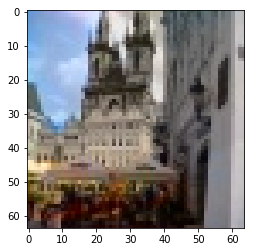

In [19]:
plt.imshow(gen_[9])
plt.show()

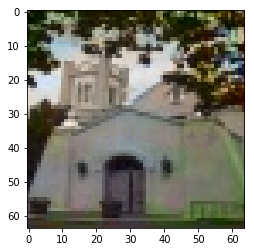

In [20]:
plt.imshow(gen_[24])
plt.show()

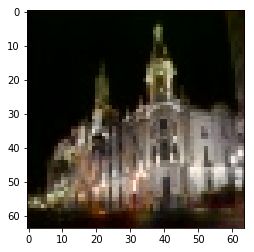

In [22]:
plt.imshow(gen_[59])
plt.show()